<h1>Word Frequency: You and I</h1>

This step contains analysis of word frequency in the Beatles songs. The <a href="https://textblob.readthedocs.io/en/dev/">TextBlob library</a> will come in handy here.

In [1]:
%matplotlib inline
import operator
import pandas as pd
import matplotlib.pyplot as plt
import math

from textblob import TextBlob, Word

from IPython.display import HTML, display
import tabulate

from collections import Counter

In [2]:
# read the source data
df = pd.read_json('data.json')

First, let's find core words, i.e. words that can be met in every Beatles' song!

In [3]:
split_cleaned_lyrics = df['lowercase_lyrics'].str.split()
lyrics_by_song = list(split_cleaned_lyrics.values)
core = set(lyrics_by_song[0])
for song in lyrics_by_song[1:]:
    core = core & set(song)
print(core)

set()


It turns out that there is not a word that is common to all Beatles songs! Even the omnipresent *the* is not present everywhere!

Well, that's interesting, which songs don't have *the*?

In [4]:
df[df['lowercase_lyrics'].str.contains('the')==False]['title']

16        I Want To Hold Your Hand
42                     Oh! Darling
44     I Want You (She's So Heavy)
55                     Her Majesty
64                  Wild Honey Pie
83                Long, Long, Long
94                  Hello, Goodbye
95       Strawberry Fields Forever
118             She Said, She Said
168     I Should Have Known Better
196               Anna (Go To Him)
201                     Love Me Do
207                Twist And Shout
Name: title, dtype: object

That's funny! Thirteen songs without *the*!

Now, let's find the words that are most common (i.e. they are contained in the biggest number of songs), the top 20:

In [5]:
lyrics_by_song = list(split_cleaned_lyrics.values)
counter_by_songs = {}
for song in lyrics_by_song:
    words_found = set()
    for word in song:
        if word in counter_by_songs:
            if word not in words_found:
                words_found.add(word)
                counter_by_songs[word] = counter_by_songs[word] + 1
        else:
            counter_by_songs[word] = 1
            words_found.add(word)

sorted_counter_by_songs = sorted(counter_by_songs.items(), key=operator.itemgetter(1), reverse=True)

for word, freq in sorted_counter_by_songs[:20]:
    print (word, freq)

the 181
to 177
you 172
and 171
i 165
a 155
me 144
that 122
in 120
my 114
of 105
be 101
it 99
know 98
all 95
so 90
is 89
love 89
on 87
your 86


Not surprisingly, the leader is *the*, and it can be found in 181 songs. Then we can see such words as *to* (177), *you* (172), *and* (171) and *I* (165).

Now the time has come to find out word frequency for all the songs.

In [6]:
def count_frequencies(cleaned_lyrics):
    '''
        Count relative frequency for each word in lyrics
    '''
    
    split_cleaned_lyrics = cleaned_lyrics.str.split()
    
    # list of all words
    lyrics = [w for song in list(split_cleaned_lyrics.values) for w in song]
    
    lyrics_count = len(lyrics)
    unique_words_count = len(set(lyrics))
    c = Counter(lyrics)
    
    # list of tuples with word and its absolute frequency
    raw_figures = sorted(c.items(), key=operator.itemgetter(1), reverse=True)
    
    # list of tuples with word and its relative frequency
    shares = [(rf[0], round(float(100*rf[1])/lyrics_count, 2)) for rf in raw_figures]
    return shares, unique_words_count, lyrics_count

How unique are the words which comprise the Beatles' songs? I use here unique words coefficient: it is unique words number divided by total words number.

In [7]:
shares, total_unique_words_number, total_words_number = count_frequencies(df['lowercase_lyrics'])

print ('Unique words number: %i' % total_unique_words_number)
print ('Total words number: %i' % total_words_number)
print ('Unique words coefficient: {:.2f}'.format(total_unique_words_number/total_words_number))

Unique words number: 2515
Total words number: 37877
Unique words coefficient: 0.07


What will we see if we plot the relative frequencies (absolute frequencies divided by the total words quantity)?

<Figure size 432x288 with 0 Axes>

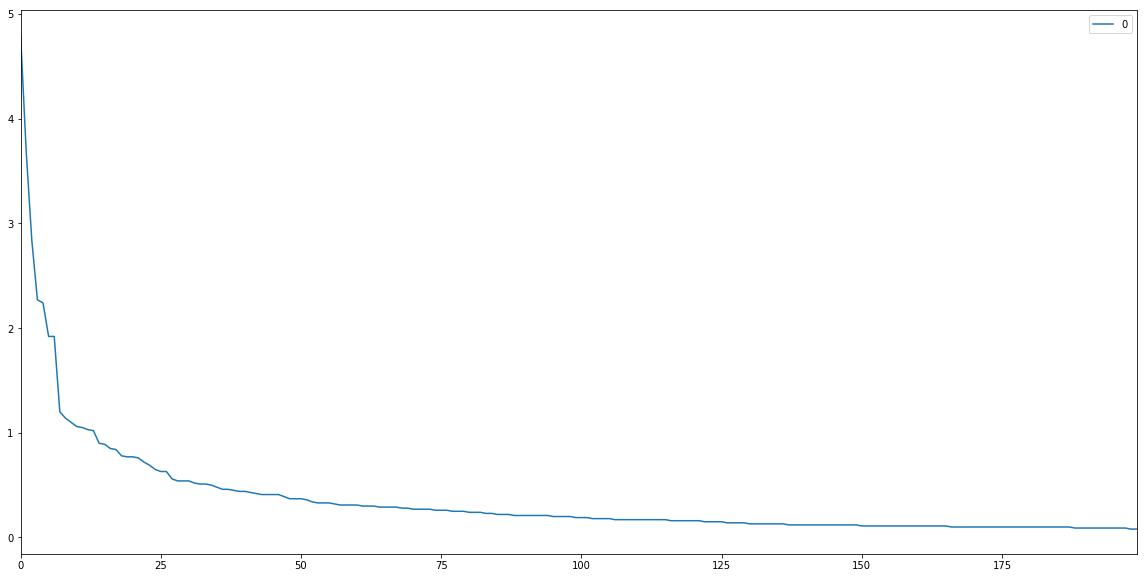

In [8]:
plt.figure()
shares_dict = [s[1] for s in shares]
df_shares = pd.DataFrame(shares_dict[:200])
df_shares.plot(figsize=(20,10))

The same in log-log scale will be as follows:

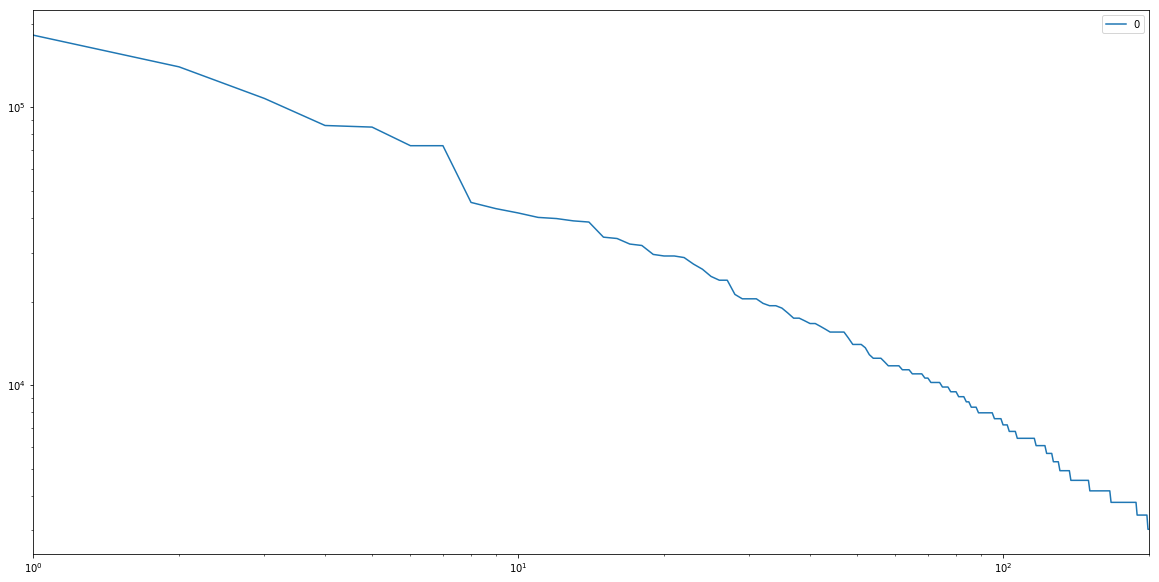

In [9]:
shares_dict = [s[1]*total_words_number for s in shares[:200]]
df_shares = pd.DataFrame(index=range(1, 201), data=shares_dict)
df_shares.plot(figsize=(20,10), loglog=True)

It's clear that the frequencies are falling drastically! Even before first 20 words they become less that 1%.

The first 20 words with their relative frequencies are as follows:

In [10]:
for word, freq in shares[:20]:
    print (word, freq)

you 4.8
i 3.69
the 2.84
me 2.27
to 2.24
and 1.92
a 1.92
love 1.2
in 1.14
it 1.1
be 1.06
my 1.05
know 1.03
all 1.02
i'm 0.9
that 0.89
don't 0.85
is 0.84
your 0.78
on 0.77


<a href="https://en.wikipedia.org/wiki/Zipf%27s_law">Zipf's law</a> states that given some corpus of natural language utterances, the frequency of any word is inversely proportional to its rank in the frequency table. Is this distribution subject to Zipf's law? If we divide the frequencies, one by one, to their neighbours (the first to the second, the second to the third, etc.), we should get roughly the same number. For the first and the second frequency the coefficient is 1.3, but for others it's not like that.

In [11]:
for i, share in enumerate(shares[:20]):
    print (share[1] / shares[i+1][1])

1.3008130081300813
1.2992957746478875
1.251101321585903
1.013392857142857
1.1666666666666667
1.0
1.6
1.0526315789473684
1.0363636363636362
1.0377358490566038
1.0095238095238095
1.0194174757281553
1.0098039215686274
1.1333333333333333
1.0112359550561798
1.0470588235294118
1.0119047619047619
1.0769230769230769
1.012987012987013
1.0


Let's plot the expected Zipf's curve and a real one in one picture.

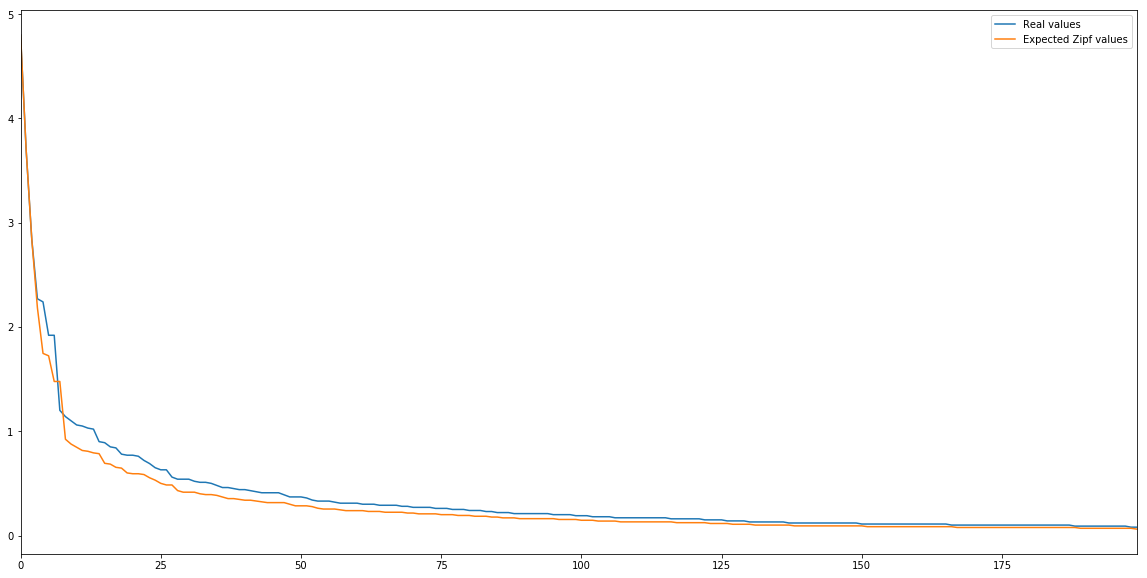

In [12]:
shares_dict = [[shares[0][1], shares[0][1]]]

shares_dict.extend([[shares[i][1], shares[i-1][1]/1.3] for i, s in enumerate(shares[0:200]) if i>0])

df_shares = pd.DataFrame(shares_dict, columns=('Real values', 'Expected Zipf values'))
df_shares.plot(figsize=(20,10))

So we see that the curve isn't strictly Zipfean by values. Still, its form is rather close to one. But the word number is not quite big anyway, so it would be a little bit naive to expect ideal match.

Anyway, the leader is *you*. It seems that *you* is more important in songs that *me*... But *I* occupies the second place. What if we sum up *I* + short verb forms (*I'm*, *I'll* etc.), and all such short verb forms with *you*?

In [13]:
i_forms = 0
you_forms = 0
for s in shares:
    if "i'" in s[0] or s[0] == "i":
        i_forms = i_forms + s[1]
    elif "you'" in s[0] or s[0] == "you":
        you_forms = you_forms + s[1]
print('Forms with I: {:.2f}'.format(i_forms))
print('Forms with you: {:.2f}'.format(you_forms))

Forms with I: 5.38
Forms with you: 5.45


Aha! *You* wins anyway!

It's interesting to compare these figures with the results presented by <a href="https://www.theguardian.com/music/datablog/2010/nov/16/beatles-lyrics-words-music-itunes">The Guardian</a>. They used the lyrics of all the songs recorded by the Beatles, so my source data contains less songs. But the top three words (*you*, *I*, *the*) and their order are the same.

Now let's look at the frequencies by years. Is there any tendecy? 

In [14]:
shares_total = []

uniq_words_numbers = []
uniq_words_coeffs = []

for year in range(1963, 1971):
    shares_year, uniq_words_number, words_total = count_frequencies(df[df['year']==year]['lowercase_lyrics'])
    print ('Unique words number: {}, unique words coefficient: {:.2f} in {}'.format(uniq_words_number, uniq_words_number/words_total, year))
    uniq_words_numbers.append(uniq_words_number/1000)
    uniq_words_coeffs.append(uniq_words_number/words_total)
    shares_total.append(shares_year)
shares_total.append(shares)

Unique words number: 566, unique words coefficient: 0.10 in 1963
Unique words number: 640, unique words coefficient: 0.11 in 1964
Unique words number: 730, unique words coefficient: 0.12 in 1965
Unique words number: 539, unique words coefficient: 0.21 in 1966
Unique words number: 901, unique words coefficient: 0.17 in 1967
Unique words number: 971, unique words coefficient: 0.16 in 1968
Unique words number: 737, unique words coefficient: 0.19 in 1969
Unique words number: 476, unique words coefficient: 0.22 in 1970


Let's plot the figures! Note that here I divide the number of unique words by 1000 to have the same scale for proper vusialization.

In [15]:
df_uniq = pd.DataFrame({'Unique words number': uniq_words_numbers, 'Unique words coefficient': uniq_words_coeffs},
                      index=range(1963, 1971))

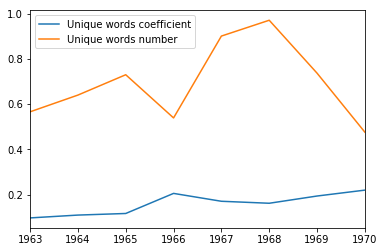

In [16]:
df_uniq.plot()

It's interesting to see that the unique words coefficient was getting higher with time, then fell down but  reached its maximum in 1970. But the number of unique words doesn't follow the coefficient at all.

Now it's time to take a look at the top of frequent words by years.

In [17]:
def show_table(shares, limit, headlines):
    '''
        Display an html table with shares data
    '''
    
    words_by_column = '<tr>'
    
    for headline in headlines:
        words_by_column = words_by_column + '<td></td><td><strong>%s</strong></td>' % str(headline)
    words_by_column = words_by_column + '</tr>'    
    
    for i in range(0, limit):

        words_by_column = words_by_column + '<tr>'

        for st in shares:
            
            words_by_column = words_by_column + '<td>{}</td><td>{:.2f}</td>'.format(st[i][0], st[i][1])

        words_by_column = words_by_column + '</tr>'    
        
    display(HTML('<table>' + words_by_column + '</table>'))

show_table(shares_total, 10, list(range(1963, 1971)) + ['Total'])

,1963,,1964,,1965,,1966,,1967,,1968,,1969,,1970,,Total
you,6.14,you,5.14,you,5.13,you,3.69,you,4.56,you,4.74,you,3.86,i,3.78,you,4.80
i,5.08,i,4.99,i,4.91,the,3.65,the,4.10,the,3.99,the,3.28,it,3.23,i,3.69
me,3.28,me,3.11,the,2.58,i,3.65,a,2.53,nah,2.70,me,2.92,you,3.05,the,2.84
and,2.17,to,2.68,me,2.53,a,2.17,to,2.29,to,2.10,to,2.68,the,2.91,me,2.27
love,1.81,love,2.36,and,2.45,to,2.06,i,2.17,a,1.91,i,2.47,be,2.54,to,2.24
to,1.79,and,2.31,to,2.44,and,1.83,and,1.99,i,1.88,all,2.29,me,2.54,and,1.92
a,1.68,a,1.76,i'm,1.47,all,1.60,know,1.76,me,1.43,a,2.08,a,2.35,a,1.92
be,1.56,the,1.49,a,1.42,of,1.45,is,1.74,in,1.41,now,1.76,yeah,2.31,love,1.20
the,1.47,my,1.42,girl,1.13,me,1.45,all,1.59,on,1.40,much,1.71,let,2.03,in,1.14
yeah,1.26,i'm,1.37,that,1.07,in,1.37,love,1.46,and,1.33,together,1.65,on,1.85,it,1.10


What can be seen from this cute table? The obvious leader is again *you*. Still its frequency is going down with time. In 1970 it loses its position to *I* and even to *it*. So 1970 is a very outstanding year in terms of word frequencies.

*I* and *the* were holding the second position during three years each, and only 1970 changed everything.

*Me* was among the leaders, but showed surprisingly low results in 1967 (not even in the top ten!).

The most typical year was 1965, where the top four was identical to total frequencies. 

It's funny, but *nah* (not the most common word in English) has surprisingly high results in 1968. Let's look at the songs that contain the word.

In [18]:
df[df['lowercase_lyrics'].str.contains('nah')]['title']

6               Hey Jude
139    Run For Your Life
Name: title, dtype: object

Of course, it's *Hey Jude* that is to blame! Because of everlasting *nah nah nah hey Jude!* in the end of the song!

Let's look at uniqueness with relation to the songs authors. This is the first time we use not the formal, but real authorship information as it's written in the <a href="https://en.wikipedia.org/wiki/List_of_songs_recorded_by_the_Beatles">Wikipedia article</a>. 

In [19]:
shares_total = []
for writer in ('Lennon', 'McCartney', 'Harrison'):
    shares_by_writer, uniq_words_number, words_total = count_frequencies(df[df['writers']==writer]['lowercase_lyrics'])
    shares_total.append(shares_by_writer)
    print ('{}: unique words number: {}, unique words coefficient: {:.2f}'.format(writer, uniq_words_number, uniq_words_number/words_total))

Lennon: unique words number: 1186, unique words coefficient: 0.12
McCartney: unique words number: 1086, unique words coefficient: 0.12
Harrison: unique words number: 581, unique words coefficient: 0.17


It's interesting to note that although Harrison has the lowest unique words number, his coefficient is higher than that of Lennon and McCartney. Now it's time to turn to the top ten of most frequent words.

In [20]:
show_table(shares_total, 10, ['Lennon', 'McCartney', 'Harrison'])

,Lennon,,McCartney,,Harrison
you,5.59,you,3.86,you,5.38
i,3.57,the,3.34,i,5.21
the,2.89,i,2.95,the,3.01
to,2.68,to,2.30,me,2.81
me,2.09,and,2.27,much,2.19
is,1.68,me,2.18,to,2.16
a,1.64,nah,1.82,don't,1.84
love,1.43,a,1.82,and,1.75
and,1.37,it,1.43,all,1.70
know,1.23,in,1.33,be,1.64


It seems that Lennon is a bit closer to Harrison than to McCartney: the latter has more evenly distributed frequencies and different order of words in the top three. Let's plot the figures (and only them, ignoring the words data) for better understanding.

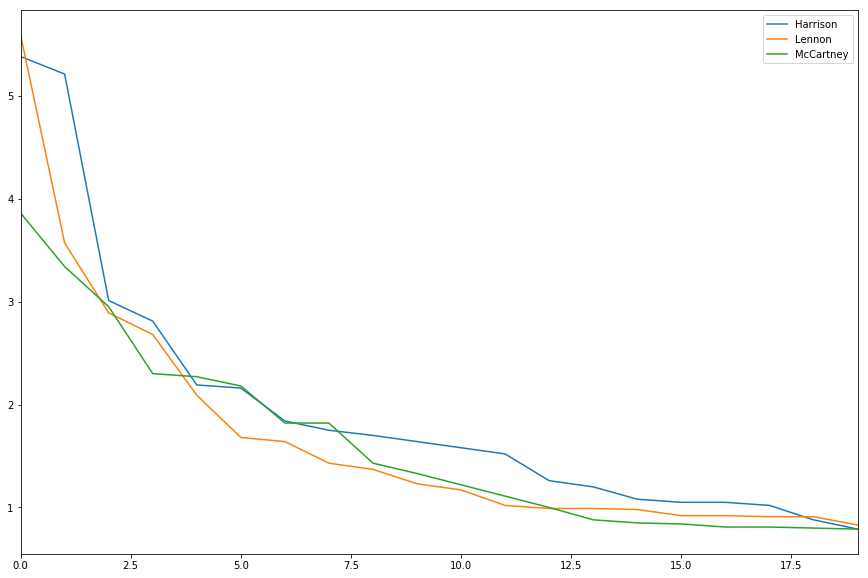

In [21]:
df_members = pd.DataFrame({'Lennon': [x[1] for x in shares_total[0][:20]], 
                    'McCartney': [x[1] for x in shares_total[1][:20]],
                    'Harrison': [x[1] for x in shares_total[2][:20]]
                   })
df_members.plot(figsize=(15,10))

Let's do the same analysis for cover songs and the original Beatles songs separately.

In [22]:
df_cover = df[df['cover']==True]
df_orig = df[df['cover']==False]

In [23]:
shares_orig, uniq_words_number, words_total = count_frequencies(df_orig['lowercase_lyrics'])

print ('Original songs: unique words number: {}, unique words coefficient: {:.2f}'.format(uniq_words_number, uniq_words_number/words_total))

shares_cover, uniq_words_number, words_total   = count_frequencies(df_cover['lowercase_lyrics'])

print ('Cover songs: unique words number: {}, unique words coefficient: {:.2f}'.format(uniq_words_number, uniq_words_number/words_total))

Original songs: unique words number: 2335, unique words coefficient: 0.07
Cover songs: unique words number: 656, unique words coefficient: 0.15


Somehow unique words coefficient is more than twice as high in cover songs!

In [24]:
shares_total = [shares_orig, shares_cover, shares]
show_table(shares_total, 10, ['Original', 'Cover', 'Total'])

,Original,,Cover,,Total
you,4.84,you,4.51,you,4.80
i,3.69,i,3.66,i,3.69
the,2.99,me,2.68,the,2.84
to,2.33,a,2.52,me,2.27
me,2.21,and,2.47,to,2.24
and,1.85,the,1.72,and,1.92
a,1.84,baby,1.58,a,1.92
love,1.25,to,1.56,love,1.20
in,1.18,it,1.46,in,1.14
be,1.11,my,1.37,it,1.10


We see that the frequencies are much alike. *You* and *I* are the favourites, and then differences begin. But the words are basically the same. Funny to see that one of the most frequent word in covers (the 7th place) is *baby*.

But what if we lemmatize the sentences? Will it change anything?

In [25]:
def lemmatize(sentence):

    words = sentence.split()
    res = ' '.join([Word(w).lemmatize() for w in words])
    return res

df['cleaned_lyrics_lemmas'] = df['lowercase_lyrics'].apply(lemmatize)

In [26]:
shares_lemmas, total_unique_words_number, total_words_number = count_frequencies(df['cleaned_lyrics_lemmas'])

print ('Unique words number: %i' % total_unique_words_number)
print ('Unique words coefficient: {:.2f}'.format(total_unique_words_number/total_words_number))

Unique words number: 2337
Unique words coefficient: 0.06


Given that the total number of words is the same, the unique words number has decreased. Because of that, the unique words coefficient has decreased as well. Let's plot the frequencies.

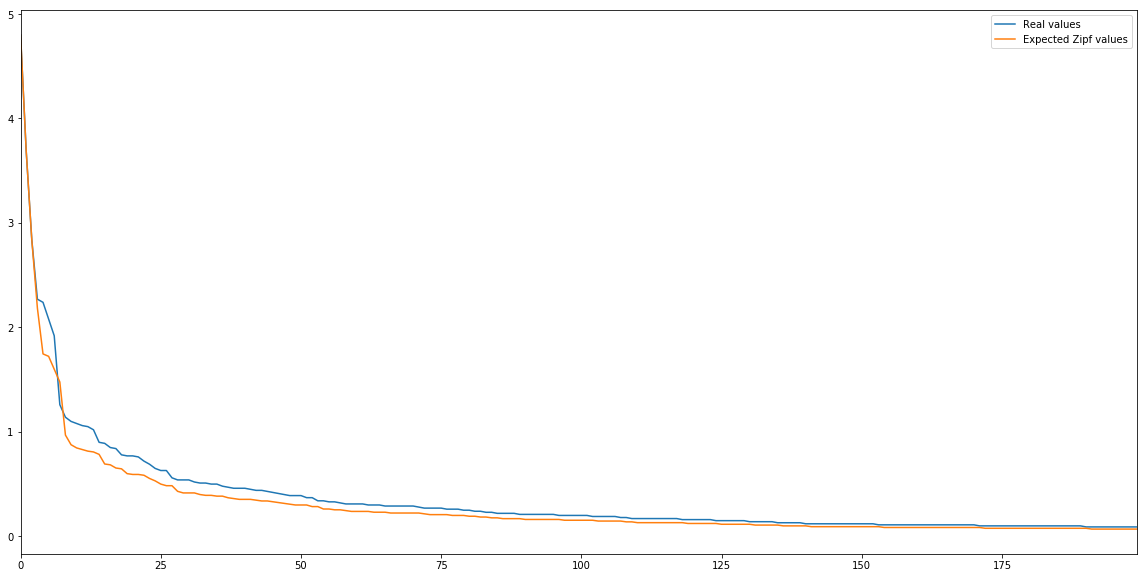

In [27]:
shares_lemmas_dict = [[shares_lemmas[0][1], shares_lemmas[0][1]]]

shares_lemmas_dict.extend([[shares_lemmas[i][1], shares_lemmas[i-1][1]/1.3] for i, s in enumerate(shares_lemmas[0:200]) if i>0])

df_shares_lemmas = pd.DataFrame(shares_lemmas_dict, columns=('Real values', 'Expected Zipf values'))
df_shares_lemmas.plot(figsize=(20,10))

Looks quite Zipfean! Now let's compare the sorted frequencies.

In [28]:
show_table([shares, shares_lemmas], 10, ['Raw', 'Lemmatized'])

,Raw,,Lemmatized
you,4.80,you,4.80
i,3.69,i,3.69
the,2.84,the,2.84
me,2.27,me,2.27
to,2.24,to,2.24
and,1.92,a,2.08
a,1.92,and,1.92
love,1.20,love,1.26
in,1.14,in,1.14
it,1.10,it,1.10


See the difference? Only *a* and *and* reversed their places, having changed their numbers. Everything else is the same. Unique words coefficient is only a little bit higher after lemmatization.

I will not go into details with lemmatized lyrics frequencies, as it's evident that the differenices between lemmatized and non-lemmatized frequencies are minimal.

But we can ask how well all these results correspond to English or British word frequencies.

So, according to the 450 million words <a href="https://www.wordfrequency.info/free.asp?s=y">Corpus of Contemporary American English</a> the first (lemmatized) five words are: *the*, *be*, *and*, *of*, *a*. 

According to Wiktionary, top 5 in frequency lists in <a href="https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/TV/2006/1-1000">TV/movies transcripts (2006)</a> (non-lemmatized) are: *you, I, to, the, a*.

Top 5 words in <a href="https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/PG/2006/04/1-10000">Project Gutenberg frequency lists</a> (2006) are: *the, of, and, to, in*.

Top 5 words in <a href="https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/Contemporary_fiction">contemporary fiction</a>, lemmatized, are: *the, I, to, and, a*.

Top 5 words in <a href="https://en.wiktionary.org/wiki/Wiktionary:Frequency_lists/Contemporary_poetry">contemporary poetry</a>, lemmatized, are: *the, I, and, to, you*.

if we turn to British National Corpus, what will we see? The <a href="http://ucrel.lancs.ac.uk/bncfreq/lists/1_2_all_freq.txt">top 5</a> (non-lemmatized) is as follows: *the, of, and, a, in*.

The same source, in <a href="http://ucrel.lancs.ac.uk/bncfreq/lists/2_2_spokenvwritten.txt">spoken English</a> only: *the, I, you, and, it*; and in <a href="http://ucrel.lancs.ac.uk/bncfreq/lists/2_3_writtenspoken.txt">written English</a> only: *the, of, and, a, in*. 

So we see that the frequency of words doesn't correspond much to the general frequency leaders (neither in American nor in British variants), and even contemporary fiction and poetry, but is rather close to TV/movies language. 

<h2>CONCLUSION</h2>

There is not a word that is common to all Beatles songs. But as for the number of songs where words can be met, the leader is *the*, found in 182 songs. Then we can see such words as *to* (178 songs), *you* (173 songs), *and* (172 songs) and *I* (166 songs).

When counting frequencies, they are falling drastically with the word's rank. Even before 20 words they become less that 1%. The leader is *you* (4.75%). Even when taking into account short verb forms, *you* is the leader. The distribution doesn't seem to correspond to Zipf's law very well, but it's more or less close.

When looking at time dynamics, the unique words coefficient was getting generally higher with time, having reached its maximum in 1970 (0.22, with 0.1 in 1963). Still, the raw number of unique words doesn't correspond to the coefficient at all.

The obvious leader every year is again *you*. Still its frequence is going down with time. In 1970 it loses its position to *I* and even to *it*. So 1970 is a very outstanding year in terms of word frequencies. *I* and *the* were holding the second position during three years each, and only 1970 changed everything. *Me* was among the leaders, but showed surprisingly low results in 1967 (not even in the top ten). The most typical year was 1965, where the top four was identical to total frequencies. The word *nah* has surprisingly high results in 1968, but just because of one song, *Hey Jude*.

When taking into consideration individual authorship, Harrison has lower unique words number, but his unique words coefficient (0.17) is higher than that of Lennon and McCartney (0.12). Unique words coefficient is unique words number divided by total words number. It seems that Lennon is a bit closer to Harrison than to McCartney: the latter has more evenly distributed frequencies and different order of words in the top three.

When looking at original songs and cover versions separately, *you* and *I* are the favourites in both cases. Then differences begin. Somehow unique words coefficient is twice as high in cover songs: obviously, their lyrics is not full of repeated words.

In lemmatized lyrics only *a* and *and* reversed their places in the top ten. Everything else is the same.

The frequency of words doesn't correspond much to the general frequency leaders (not in American nor in British variants), and even in contemporary fiction and poetry, but is rather close to TV/movies language.